In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.core.pipeline import run_pipeline
from src.evaluation.regime import ic_by_regime


In [2]:
REGION = "austin"
HORIZON = 12

In [10]:
# 1️⃣ 构建基础数据（只做一次）
df = run_pipeline(REGION)

# 2️⃣ Phase 5 显式定义 alpha
df["alpha_signal"] = df["score_xs"]

# 3️⃣ 所有 robustness / gating / IC / corr 都在下面
df[["alpha_signal", "score_xs", "fwd_return", "regime"]].dropna().shape


(180, 4)

In [11]:
# affordability gate：只在 DOWN regime 打开
df["affordability_filter"] = (df["regime"] == "down").astype(float)

df["affordability_filter"].value_counts()


affordability_filter
0.0    106
1.0     86
Name: count, dtype: int64

In [12]:
df["alpha_gated"] = df["affordability_filter"] * df["alpha_signal"]


In [13]:
df[["alpha_signal", "alpha_gated", "fwd_return", "regime"]].dropna().shape


(180, 4)

In [14]:
ic_by_regime(df, signal_col="alpha_signal")
ic_by_regime(df, signal_col="alpha_gated")


/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,ic,positive_ratio,n_obs
regime,,,
down,-0.434744,0.337838,74
up,NaN,0.000000,106


In [15]:
# alpha exposure size
df["alpha_abs"] = df["alpha_signal"].abs()
df.groupby("regime")["alpha_abs"].mean()

# gated exposure size
df["alpha_gated_abs"] = df["alpha_gated"].abs()
df.groupby("regime")["alpha_gated_abs"].mean()


regime
down    0.565366
up      0.000000
Name: alpha_gated_abs, dtype: float64

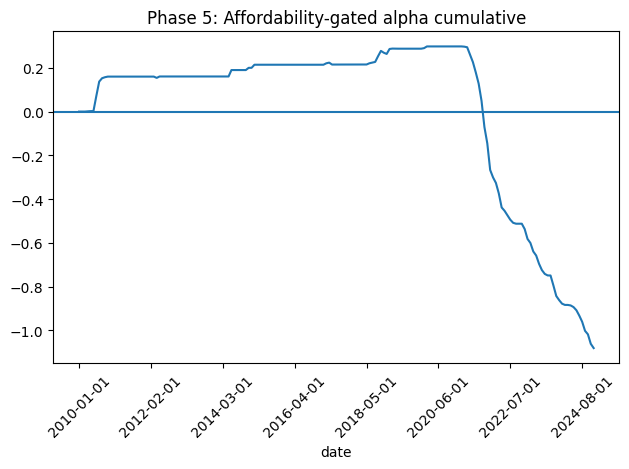

In [16]:
bt = df.dropna(subset=["alpha_gated", "fwd_return"]).copy()
bt["ret"] = bt["alpha_gated"] * bt["fwd_return"]

equity = bt.set_index("date")["ret"].cumsum()
equity.plot(title="Phase 5: Affordability-gated alpha cumulative")
plt.axhline(0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
df["alpha_gated_neg"] = -df["alpha_gated"]

ic_by_regime(df, signal_col="alpha_gated_neg")


/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,ic,positive_ratio,n_obs
regime,,,
down,0.434744,0.662162,74
up,NaN,0.000000,106


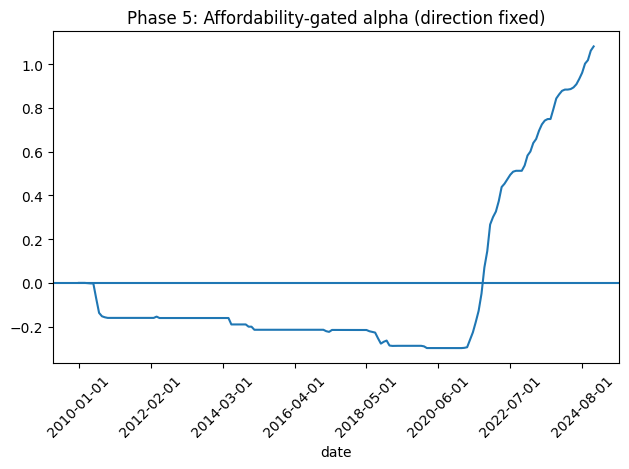

In [19]:
bt = df.dropna(subset=["alpha_gated_neg", "fwd_return"]).copy()
bt["ret"] = bt["alpha_gated_neg"] * bt["fwd_return"]

equity = bt.set_index("date")["ret"].cumsum()
equity.plot(title="Phase 5: Affordability-gated alpha (direction fixed)")
plt.axhline(0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
